In [1]:
import numpy as np
from returns.maybe import Maybe, Some, Nothing
from numerical_methods.linear_direct_methods import (
    gaussian_elimination,
    back_substitution,
    lu_factorization,
    lu_solve,
    gauss_solve,
)
import time
import pandas as pd
from returns.curry import partial

## Part 1

check hw2 results


In [2]:
A = np.matrix([[2, 4, 5], [7, 6, 5], [9, 11, 3]], dtype=float)
b = np.array([3, 2, 1]).reshape((3, 1))
U, L = lu_factorization(A).unwrap()
L, U

(array([[1.   , 0.   , 0.   ],
        [3.5  , 1.   , 0.   ],
        [4.5  , 0.875, 1.   ]]),
 matrix([[  2.    ,   4.    ,   5.    ],
         [  0.    ,  -8.    , -12.5   ],
         [  0.    ,   0.    ,  -8.5625]]))

In [3]:
gaussian_elimination(A, pivot="partial").unwrap()

(matrix([[ 9.        , 11.        ,  3.        ],
         [ 0.        ,  1.55555556,  4.33333333],
         [ 0.        ,  0.        ,  9.78571429]]),
 array([[ 1.        ,  0.        ,  0.        ],
        [ 0.77777778,  1.        ,  0.        ],
        [ 0.22222222, -1.64285714,  1.        ]]))

In [4]:
mat, _ = gaussian_elimination(np.hstack((A, b))).unwrap()
back_substitution(mat[:, :-1], mat[:, [-1]])

array([[-0.25547445],
       [ 0.13868613],
       [ 0.59124088]])

In [5]:
gauss_solve(A, b)

<Some: [[-0.25547445]
 [ 0.13868613]
 [ 0.59124088]]>

In [6]:
lu_solve(L, U, b)

array([[-0.25547445],
       [ 0.13868613],
       [ 0.59124088]])

## Part 2

error analysis and time analysis


In [7]:
def get_err(n: int, repeat: int, changeA: bool, onlyRandomA: bool):
    x1_errs = []
    x2_errs = []
    x3_errs = []
    x1_time = []
    x2_time = []
    x3_time = []

    def get_A():
        A = np.random.normal(size=(n, n))
        if not onlyRandomA:
            A += 5 * np.eye(n)
        return A

    A = get_A()
    U, L = None, None

    for _ in range(repeat):
        if changeA:
            A = get_A()
        b = np.random.normal(size=(n, 1))

        x1_start = time.time()
        x1 = gauss_solve(A, b).unwrap()
        x1_time.append(time.time() - x1_start)

        x2_start = time.time()
        if changeA or U is None or L is None:
            U, L = lu_factorization(A).unwrap()
        x2 = lu_solve(L, U, b)
        x2_time.append(time.time() - x2_start)

        x3_start = time.time()
        x3 = np.linalg.solve(A, b)
        x3_time.append(time.time() - x3_start)

        x1_errs.append(np.linalg.norm(A @ x1 - b))
        x2_errs.append(np.linalg.norm(A @ x2 - b))
        x3_errs.append(np.linalg.norm(A @ x3 - b))

    return map(np.mean, [x1_errs, x2_errs, x3_errs, x1_time, x2_time, x3_time])


def test(ns, repeat=10, changeA=True, onlyRandomA=False):
    ts = list(zip(*map(lambda n: get_err(n, repeat, changeA, onlyRandomA), ns)))
    err_df = pd.DataFrame(
        {
            "n": ns,
            "GE": ts[0],
            "LU": ts[1],
        }
    )
    exec_time = pd.DataFrame({"n": ns, "GE": ts[3], "LU": ts[4], "NP": ts[5]})
    return err_df, exec_time


ns = [50, 100, 250, 500]

$$
A = 5 \times I + R
$$
for different A every time


In [8]:
err_df, exec_time = test(ns)

In [9]:
print(err_df.to_latex(index=False))
err_df

\begin{tabular}{rrr}
\toprule
  n &           GE &           LU \\
\midrule
 50 & 6.045837e-13 & 4.909461e-13 \\
100 & 1.678723e-11 & 2.191986e-11 \\
250 & 1.421434e-10 & 1.297850e-10 \\
500 & 5.481989e-09 & 2.989905e-09 \\
\bottomrule
\end{tabular}



/var/folders/tc/kg28gjm16xgc5t5lyfvh_5sw0000gn/T/ipykernel_21263/2517424522.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(err_df.to_latex(index=False))


,n,GE,LU
0,50,6.045837e-13,4.909461e-13
1,100,1.678723e-11,2.191986e-11
2,250,1.421434e-10,1.297850e-10
3,500,5.481989e-09,2.989905e-09


<AxesSubplot:title={'center':'Execution Time Different A'}, xlabel='n', ylabel='sec'>

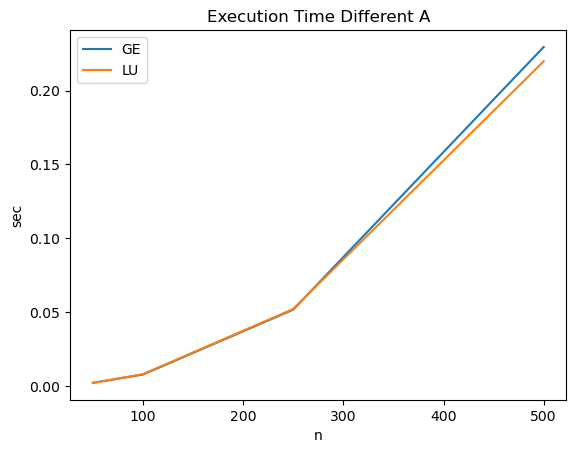

In [10]:
exec_time.plot(
    x="n",
    y=["GE", "LU"],
    title="Execution Time Different A",
    legend=True,
    ylabel="sec",
)

for same $A$ different $b$ every time


In [11]:
_, exec_time_same_A = test(ns, changeA=False)

<AxesSubplot:title={'center':'Execution Time Same A'}, xlabel='n', ylabel='sec'>

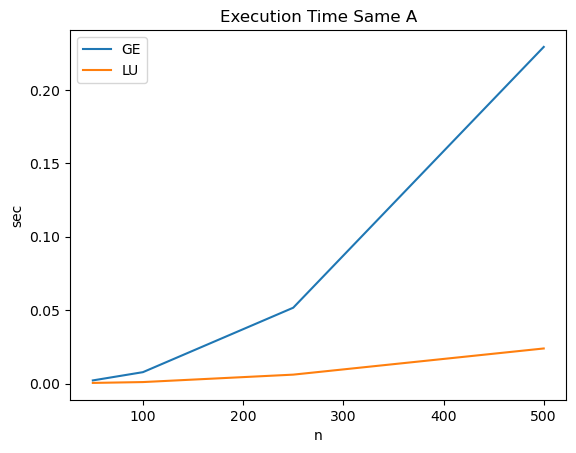

In [12]:
exec_time_same_A.plot(
    x="n",
    y=["GE", "LU"],
    title="Execution Time Same A",
    legend=True,
    ylabel="sec",
)

$$
\hat{A} = R
$$
different $\hat{A}$ every time


In [13]:
err_df_R, exec_time_R = test(ns, onlyRandomA=True)

In [14]:
print(err_df_R.to_latex(index=False))
err_df_R

\begin{tabular}{rrr}
\toprule
  n &           GE &           LU \\
\midrule
 50 & 4.083414e-12 & 3.737011e-12 \\
100 & 1.153413e-11 & 1.861228e-11 \\
250 & 5.575676e-10 & 7.421184e-10 \\
500 & 7.454811e-09 & 3.788592e-09 \\
\bottomrule
\end{tabular}



/var/folders/tc/kg28gjm16xgc5t5lyfvh_5sw0000gn/T/ipykernel_21263/2575795165.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(err_df_R.to_latex(index=False))


,n,GE,LU
0,50,4.083414e-12,3.737011e-12
1,100,1.153413e-11,1.861228e-11
2,250,5.575676e-10,7.421184e-10
3,500,7.454811e-09,3.788592e-09


<AxesSubplot:title={'center':'Execution Time Different A'}, xlabel='n', ylabel='sec'>

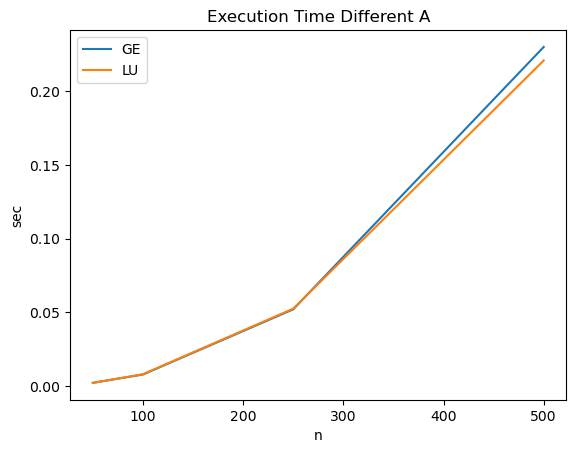

In [15]:
exec_time_R.plot(
    x="n",
    y=["GE", "LU"],
    title="Execution Time Different A",
    legend=True,
    ylabel="sec",
)

same $\hat{A}$ different $b$


In [16]:
_, exec_time_R_same_A = test(ns, changeA=False, onlyRandomA=True)

<AxesSubplot:title={'center':'Execution Time Same A'}, xlabel='n', ylabel='sec'>

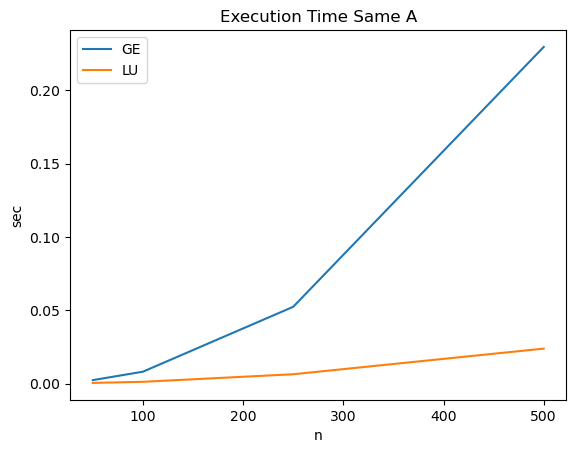

In [17]:
exec_time_R_same_A.plot(
    x="n",
    y=["GE", "LU"],
    title="Execution Time Same A",
    legend=True,
    ylabel="sec",
)